In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.signal import fftconvolve as conv
from scipy.special import j1
# no tensorflow today :(

# Incoherent vs coherent point spread functions

* We typically model optical fields as complex valued: $E$
* Under normal circumstances, _we can only measure intensity_, which may be thought of as magnitude of field squared: $|E|^2$
* Image formation is governed by convolution of the object with a point spread function (PSF). 
* Convolutions may be thought of as simply a weighted sum of shifted PSFs. 

As such, whether an imaging system is coherent or incoherent is directly related to what happens when you add two complex-valued PSFs together -- in other words, do they interfere? Consider two fields $E_1$ and $E_2$ which are superimposed at a detector that only measures intensity:

$I=|E_1+E_2|^2=|E_1|^2+\gamma(E_1^*E_2+E_2^*E_1)+|E_2|^2$

The middle term is the interference term, while the first and third term are the intensities of the two fields individually. $\gamma$ is a factor between 0 and 1 called the _degree of coherence_ between the two fields. When the two fields are fully coherent with each other, $\gamma=1$, and we refer to the imaging system as a coherent imaging system. 

$I_{coherent}=|E_1|^2+E_1^*E_2+E_2^*E_1+|E_2|^2$

When the two fields are completely incoherent with each other (the two fields _cannot_ interfere), $\gamma=0$ and the detector detects only the independent summation of the individual intensities:

$I_{incoherent}=|E_1|^2+E_2|^2$

This is the incoherent imaging regime. In practice what this means is that we can ignore field and just operate with intensities.

Any other value of $\gamma$ refers to a _partially coherent_ imaging system, but we won't concern ourselves today with partial coherence as it's a much more involved topic.

Let's informally analyze the effects of coherence on the image.

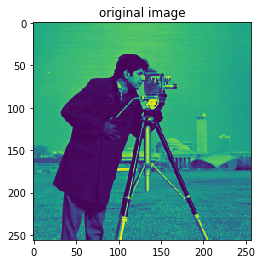

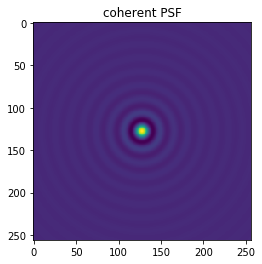

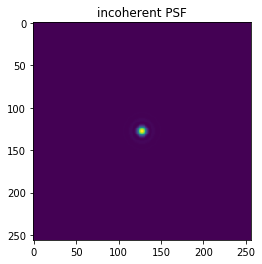

In [2]:
# load BW image:
obj = plt.imread('cameraman.png')
plt.imshow(obj)
plt.title('original image')
plt.show()

# set up spatial coordinates
xy = np.linspace(-10, 10, obj.shape[0])  # um
x, y = np.meshgrid(xy, xy)
r = np.sqrt(x**2+y**2)  # distance from origin

# consider a jinc point spread function (PSF), which corresponds to a circular aperture
def jinc(r):
    return j1(r)/r
PSF_coherent = jinc(r*5)
PSF_incoherent = np.abs(PSF_coherent)**2

plt.imshow(PSF_coherent)
plt.title('coherent PSF')
plt.show()

plt.imshow(PSF_incoherent)
plt.title('incoherent PSF')
plt.show()

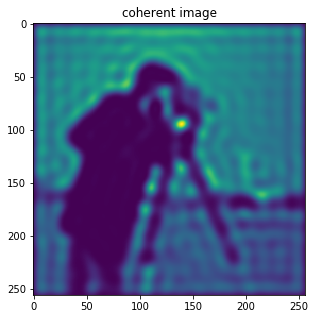

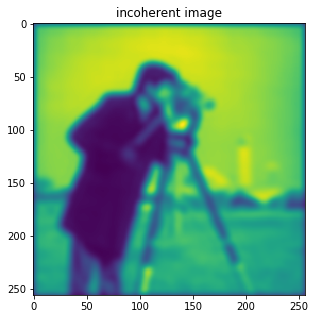

In [3]:
# convolve with PSF:
im_coherent = np.abs(conv(obj, PSF_coherent, mode='same'))**2
im_incoherent = conv(obj, PSF_incoherent, mode='same')

plt.figure(figsize=(5, 5))
plt.imshow(im_coherent)
plt.title('coherent image')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(im_incoherent)
plt.title('incoherent image')
plt.show()

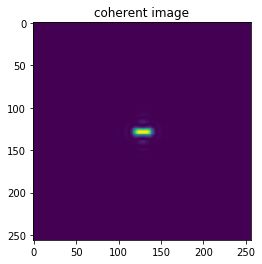

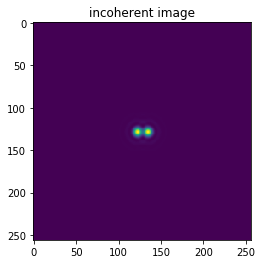

In [4]:
# two point test to compare resolution
obj2 = np.zeros_like(obj)
d = 12  # separation between two points
obj2[128, 128+d//2] = 1
obj2[128, 128-d//2] = 1

im2_coherent = np.abs(conv(obj2, PSF_coherent, mode='same'))**2
im2_incoherent = conv(obj2, PSF_incoherent, mode='same') 

plt.imshow(im2_coherent)
plt.title('coherent image')
plt.show()

plt.imshow(im2_incoherent)
plt.title('incoherent image')
plt.show()

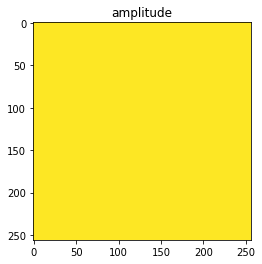

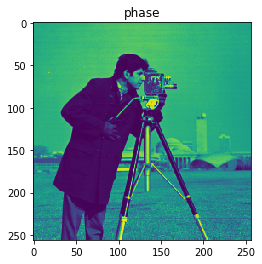

In [5]:
# where incoherent imaging fails: phase-only objects
obj3 = np.exp(1j*obj/255*2*np.pi)  # create a phase image from cameraman
plt.imshow(np.abs(obj3))
plt.clim([0, 1])
plt.title('amplitude')
plt.show()

plt.imshow(np.angle(obj3))
plt.title('phase')
plt.show()

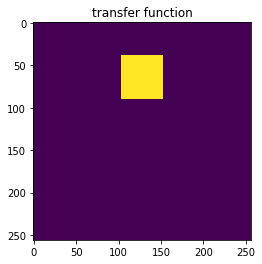

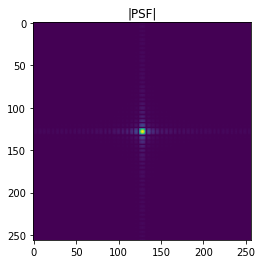

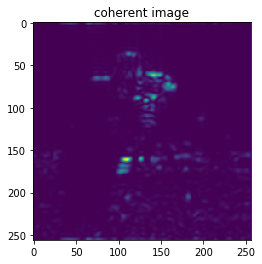

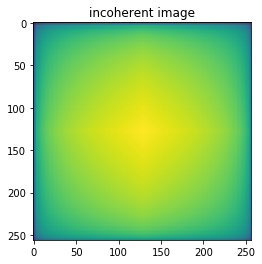

In [6]:
# create a bandpass transfer function:
TF = (np.abs(y+5))<2*(np.abs(x)<2)
plt.imshow(TF)
plt.title('transfer function')
plt.show()

PSF_incoherent = np.abs(ifftshift(ifft2(TF)))
plt.imshow(PSF_incoherent)
plt.title('|PSF|')
plt.show()


im3_coherent = np.abs(ifft2(fft2(obj3)*fftshift(TF)))**2
im3_incoherent = conv(np.abs(obj3), PSF_incoherent, mode='same')  # incoherent imaging is insensitive to object phase

plt.imshow(im3_coherent)
plt.title('coherent image')
plt.show()

plt.imshow(im3_incoherent)
plt.title('incoherent image')
plt.show()

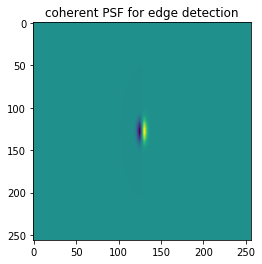

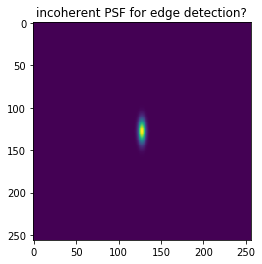

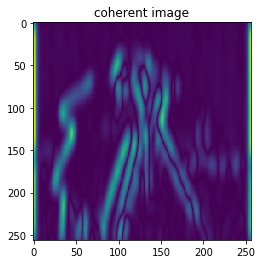

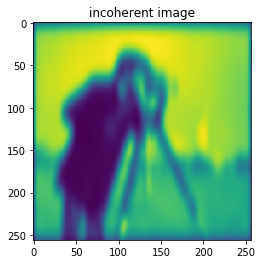

In [7]:
# another advantage of coherent imaging: negative values
# consider horizontal edge detection:
PSF_coherent = np.exp(-(x**2/.1+y**2/1))*np.sin(x)
PSF_incoherent = np.exp(-(x**2/.1+y**2/1))

plt.imshow(PSF_coherent)
plt.title('coherent PSF for edge detection')
plt.show()

plt.imshow(PSF_incoherent)
plt.title('incoherent PSF for edge detection?')
plt.show()

im_incoherent = conv(obj, PSF_incoherent, mode='same')
im_coherent = np.abs(conv(obj, PSF_coherent, mode='same'))

plt.imshow(im_coherent)
plt.title('coherent image')
plt.show()

plt.imshow(im_incoherent)
plt.title('incoherent image')
plt.show()

# Summary
Qualitatively we found that incoherent imaging produces higher resolution. Coherent imaging produces ringing artifacts around edges because in practice we use apertures which have sharp cutoffs. However, coherent imaging has advantages -- it in principle can detect phase-only objects, and because it gives us access to negtive values we can produce more interesting filter such as edge detectors. More generally, it allows a wider range of possible filter designs, such as those used in CNNs, whereas positive-only filters can't do much more than blur.

See https://ocw.mit.edu/courses/mechanical-engineering/2-71-optics-spring-2009/video-lectures/lecture-22-coherent-and-incoherent-imaging/MIT2_71S09_lec22.pdf for a more detailed treatment.